# Image Classification from Scratch
#### A Deep learning for Computer Vision Demo Environment by Tillmann Brodbeck
This is a demo environment containing all the necessary steps to install a dataset, install a deep learning model and analyze its performance, subsequently.
In general it was made sure that every critical step in the Python code is commented and "speaking" variables were used to make every bit of code understandable (and to avoid commenting every single line).

The first section is about setting up your environment from scratch. Here, a working python3 environment is a prerequisite. 
It is explained how to download an dataset with `wget`. Additionally all required python libraries are listed.

The second section demonstrates which hyperparameters are set and how different hyperparameter configurations can be managed. Additionally it shows how the data preprocessing is done and demonstrates two ways of installing a dataset for training: CIFAR10 is downloaded from `keras` directly and imagenette is imported from disk.

Section 3 demonstrates how the models are created and displays the exact architectures that are used in this demonstration in an easy way, built with as `Sequential` `keras` models. Additionally, it demonstrates how the training process can be initiated and outputs the `accuracy` metric and the categorical crossentropy as loss in real time while training.

Section 4 demonstrates how the model and its results can be saved to disk using `pickle`.

Finally, section 5 shows how trained models can be analyzed. Optionally, models can be imported from disk and tested against the dataset created in section 2. Finally it is shown how simple plots of the training and testing metrics can be created using `matplotlib.pyplot`.

## 1. Setup your Environment

### Download the imagenette Dataset
To download the imagenette dataset make sure you have a bash-like environment and `wget` and `tar` installed.

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xf imagenette2.tgz

### Install the required Packages into your Environment
Anaconda is recommended.

The most recent versions right now and the tested version are 
```
keras==2.3.1
pickle==0.7.5
pillow==7.1.2
tensorflow== 2.0.0
```

In [ ]:
!pip3 install keras pickle pillow tensorflow

### Import the required Libraries into Python

In [1]:
from keras.activations import relu
from keras.layers import Activation, Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.models import load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import os
import pickle
import sys
import tensorflow as tf

Using TensorFlow backend.


### Set the Path for the imagenette Dataset
Per default the imagenettePath is `'imagenette2/'` (There has be a slash at the end)

In [2]:
imagenettePath = 'imagenette2/'

### Choose a Dataset
Possible datasets are `'cifar10'` and `'imagenette'`

In [3]:
# dataset = 'cifar10'
dataset = 'imagenette'

## 2. Prepare the Dataset and the Configuration

In [4]:
""" the hyperparameters """
hyperparameterChoice = 2

# different parameter configurations can be tracked in dictionaries for quick comparisons
if hyperparameterChoice==0: # test configuration with one epoch only
    hyperparameter = {
        'batchSize': 128,
        'keepProb': .5,
        'activationConv': 'relu',
        'activationDense': 'relu',
        'epochs': 1,
        'denseLayers': 1,
        'batchNorm': False,
    }
elif hyperparameterChoice==1:
    hyperparameter = {
        'batchSize': 128,
        'keepProb': .5,
        'activationConv': 'relu',
        'activationDense': 'relu',
        'epochs': 30,
        'denseLayers': 1,
        'batchNorm': False,
    }
elif hyperparameterChoice==2:
    hyperparameter = {
        'batchSize': 128,
        'keepProb': .25,
        'activationConv': 'relu',
        'activationDense': 'relu',
        'epochs': 30,
        'denseLayers': 2,
        'batchNorm': True,
    }

print('Chosen Hyperparameters:', hyperparameter)

batchSize = hyperparameter['batchSize']
keepProb = hyperparameter['keepProb']
activationConv = hyperparameter['activationConv']
activationDense = hyperparameter['activationDense']
epochs = hyperparameter['epochs']
denseLayers = hyperparameter['denseLayers']
batchNorm = hyperparameter['batchNorm']

""" the loading and preprocessing the data """
# setup image preprocessing
datagen = ImageDataGenerator(horizontal_flip=True, 
                             rescale=1./255, # scales the images to values between 0 and 1
                             width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                             rotation_range=1 # rotate the images randomly in the range of 1 degree
                            )

if dataset=='cifar10': # downloads CIFAR10 from keras
    from keras.datasets import cifar10
    from keras.utils import to_categorical
    
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print(x_train.shape[0], 'Train Samples')
    print(x_test.shape[0], 'Test Samples')

    datagen.fit(x_train)
    train = datagen.flow(x_train, y_train, batch_size=batchSize, shuffle=True)
    val = (x_test, y_test)
    
elif dataset=='imagenette': # installs `imagenette` from disk
    # load train data
    train = datagen.flow_from_directory("{}train/".format(imagenettePath), class_mode="categorical", shuffle=True, batch_size=batchSize, target_size=(224, 224))
    # load val data
    val = datagen.flow_from_directory("{}val/".format(imagenettePath), class_mode="categorical", shuffle=True, batch_size=batchSize, target_size=(224, 224))
else:
    raise ValueError(f'Invalid Value: {dataset} - only cifar10 and imagenette are valid')

Chosen Hyperparameters: {'batchSize': 128, 'keepProb': 0.25, 'activationConv': 'relu', 'activationDense': 'relu', 'epochs': 30, 'denseLayers': 2, 'batchNorm': True}
Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## 3. Create and Train the Model

In [ ]:
""" the architectures """

if dataset=='imagenette':
    architecture = 1 # Architecture 1 is tuned to perform well on the imagenette dataset (but it does not perform too well on CIFAR)
if dataset=='cifar10':
    architecture = 2 # Architecture 2 performs better for CIFAR, but has a training time that is too large for 'imagenette' (more than 1h per epoch on my resources)

if architecture==1:
    model = Sequential()

    # 1st conv block
    model.add(Conv2D(16, (5, 5), input_shape=train[0][0].shape[1:], strides=(1, 1), padding='same'))
    model.add(Activation(activationConv))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

    # 2nd conv block
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation(activationConv))
    model.add(MaxPool2D(pool_size=(2, 2)))
    if batchNorm:
        model.add(BatchNormalization())

    # 3rd conv block
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation(activationConv))
    model.add(MaxPool2D(pool_size=(2, 2)))
    if batchNorm:
        model.add(BatchNormalization())
    model.add(Dropout(keepProb))
    
    # ANN block
    model.add(Flatten())
    for i in range(denseLayers):
        model.add(Dense(units=100, activation=activationDense))
    model.add(Dropout(keepProb))

    # output layer
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

elif architecture==2:
    model = Sequential()
    # 1st 2xconv block
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=train[0][0].shape[1:]))
    model.add(Activation(activationConv))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation(activationConv))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(keepProb))

    # 2nd 2xconv block
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation(activationConv))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation(activationConv))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(keepProb))

    # ANN block
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # output layer
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

else:
    raise ValueError(f'architecture number {architecture} is out of range')
    
model.summary()
# compile model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

""" the training """
# fit on data
result = model.fit_generator(train, epochs=epochs, validation_data=val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        12832     
_________________________________________________________________
activation_2 (Activation)    (None, 56, 56, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)       

### Create a notification or alarm as soon as the training is done.
This is optional and if you are not on MacOS you might want to adapt the code to fit your setup.

In [ ]:
!osascript -e 'display notification "is done!" with title "Nobebook"'
!say 'Notebook done!''

## 4. Save the Model and the Results to Disk

In [5]:
outDir = 'results/'
if not os.path.exists(outDir):
    os.makedirs(outDir)
runName = '{}{}_{}'.format(outDir, architecture, hyperparameterChoice)
model.save('{}.model'.format(runName))
with open('{}result.p'.format(runName), 'wb') as file:
    pickle.dump(result, file)
print(f'Models and Training Output were saved to the Directory {outDir}')

NameError: name 'architecture' is not defined

## 5. Analyze the Results
### Load the data from a file
This is optional and will overwrite the results of the previous training if not `None`.

In [5]:
loadResultsFrom = 'out/out1_2' # if None, it takes current ouput and model. Else specify outDir and runName (e.g: 'outDir/1_2') TODO change to default

if loadResultsFrom:
    model = load_model('{}.model'.format(loadResultsFrom))
    with open('{}history.p'.format(loadResultsFrom), 'rb') as file: # TODO change history
        output = pickle.load(file)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




### Evaluate the Model on the current Test Set

In [9]:
print('This will return the current test loss and accuracy:') # TODO run again
model.evaluate_generator(val, verbose=1)

This will return the Test loss and Accuracy:
31/31 [==============================] - 83s 3s/step


[4.563850402832031, 0.10420382022857666]

### Create Training Plots

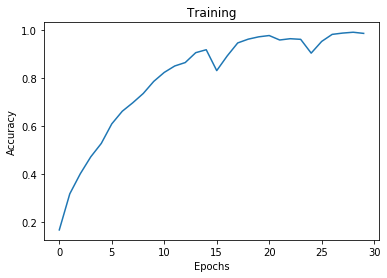

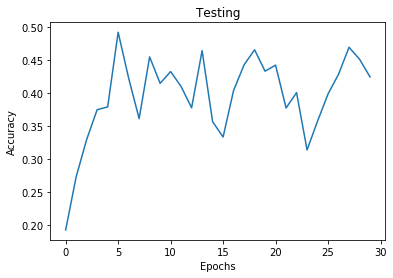

In [6]:
import matplotlib.pyplot as plt

for plotType in ['accuracy', 'val_accuracy']:
    plt.plot(output.history[plotType])
    if plotType=='accuracy':
        plt.title('Training')
    if plotType=='val_accuracy':
        plt.title('Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()